# Global temperature

Get global average as a function of time, starting at 1850   
Forecast to 2040
Output the data  

In [254]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from   sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [255]:
# Get data

colnames    = ['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty']
newnames    = ['dt', 'at', 'atu']
datatypes   = {'dt': 'str','at':'float32','atu':'float32'}
df0 = pd.read_csv("../Input/Temperature/GlobalTemperatures.csv", 
                            usecols = colnames, 
                            dtype = datatypes)
df0.columns = newnames
df0 = df0[pd.notnull(df0['at'])]
df0['year'] = df0['dt'].map(lambda x: int(x.split('-')[0]))
df0['month'] = df0['dt'].map(lambda x: int(x.split('-')[1]))
df0['dt'] = df0['dt'].map(lambda x: str(x.rsplit('-',1)[0]))
df0.head(3)

,dt,at,atu,year,month
0,1750-01,3.034,3.574,1750,1
1,1750-02,3.083,3.702,1750,2
2,1750-03,5.626,3.076,1750,3


# Plot global average annual temperature

In [3]:
df0Annual=df0.groupby('year').mean()
df0Annual=df0Annual.drop('month',axis=1)
df0Annual.head(3)

,at,atu
year,,
1750,8.719364,2.637818
1751,7.976143,2.781143
1752,5.779833,2.977000


In [4]:
df0Annual.columns

Index(['at', 'atu'], dtype='object')

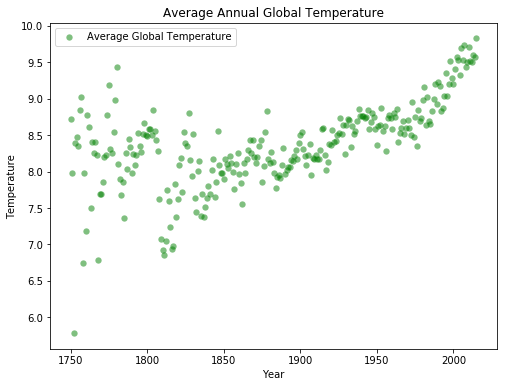

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(df0Annual.index, df0Annual['at'], s=40, c='green', alpha=0.5, linewidths=0, label='Average Global Temperature')
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Average Annual Global Temperature')
#plt.savefig('AnnualGlobalTemperature.png')

In [6]:
# Because there's such high variance before 1850, 
# I will keep only the later data
df0=df0.loc[df0['year']>=1850]
df0.head(3)
df0Annual=df0Annual.loc[df0Annual.index>=1850]
df0Annual.head(3)

,at,atu
year,,
1850,7.900667,0.876417
1851,8.178583,0.881917
1852,8.100167,0.918250


# Do linear regression

In [7]:
def addpolynomialfeatures(subX, x):
    subX['x2'] = x**2
    subX['x3'] = x**3
    subX['x4'] = x**.5
#     subX['x5'] = np.sin(x)
#     subX['x6'] = np.cos(x)
    subX['x8'] = np.log(x)

In [8]:
X         = pd.DataFrame(df0Annual.index)
addpolynomialfeatures(X, X['year'])
y         = pd.DataFrame(df0Annual['at'])
X.index   = X['year']
Xy        = pd.concat([X,y], axis=1)
regresor  = linear_model.LinearRegression()
regresor2 = linear_model.BayesianRidge(compute_score=True)
regresor2.fit(X, y)
predict2   = regresor2.predict(X)
regresor.fit(X,y,5000)
predict   = regresor.predict(X)
print('Coefficients: \n', regresor.coef_)
print("Mean of error: %.2f" % np.mean((predict - y) ** 2))

Coefficients: 
 [[  2.68507471e+03  -4.68256362e-01   4.88180430e-05  -1.24217088e+05
   -1.80955059e+04]]
Mean of error: 0.04


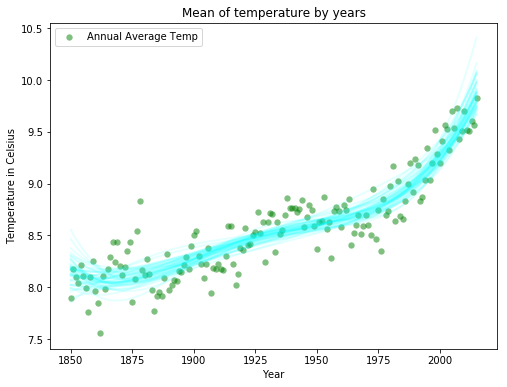

In [292]:
plt.figure(figsize=(8,6))
plt.scatter(df0Annual.index, df0Annual['at'], s=40, c='green', alpha=0.5, linewidths=0, label='Annual Average Temp')
for i in range(50):
    sample = Xy.sample(n=40) #randomly sample 40 points
    X_test = sample[Xy.columns[:-1]]
    y_test = sample[Xy.columns[-1]]
    regresor.fit(X_test,y_test)
    predict   = regresor.predict(X)
    plt.plot(df0Annual.index, predict, c='cyan', alpha=0.1, linewidth=2.)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Temperature in Celsius')
plt.title('Mean of temperature by years')
#plt.savefig('AnnualGlobalTemperature_LinReg.png')

In [10]:
graph = df0Annual['at'].reset_index()
graph = graph.set_index('year')
graph = graph.fillna(0)

graph.head(3)

plt.figure(figsize=(8,6))
graph.plot()
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Average Annual Global Temperature')
fig=plt.gcf()
fig.set_size_inches(18,8)

,at
year,
1850,7.900667
1851,8.178583
1852,8.100167


# Forecast annual global temperatures

## Autoregression using MLP on multiple inputs

In [46]:
import math
from keras.models import Sequential
from keras.layers import Dense

import timeit as ti
import os
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x) # Alert when code finishes running

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
# fix random seed for reproducibility
np.random.seed(10)
# preview the dataset
df0.head(3)

,dt,at,atu,year,month
1200,1850-01,0.749,1.105,1850,1
1201,1850-02,3.071,1.275,1850,2
1202,1850-03,4.954,0.955,1850,3


In [15]:
# Graph inputs (monthly temperature and temperature uncertainty)

In [16]:
# start with annual forecast

In [236]:
# Split train and test sets
data=df0Annual
totLen=len(data)
train_size = int(totLen * 0.8)
test_size = totLen - train_size

train, test = data[0:train_size], data[train_size:totLen] 
print('train',len(train),', test',len(test))
train.head(3)

train 132 , test 34


,at,atu
year,,
1850,7.900667,0.876417
1851,8.178583,0.881917
1852,8.100167,0.918250


## Setup input data for autoregression for chosen look_back

In [238]:
# re-shape dataset for autoregression 
nvars=2
look_back=6
trainX = np.zeros((len(train)-look_back-1,  2*look_back)) 
trainY = np.zeros((len(train)-look_back-1,  nvars))
testX  = np.zeros((len(test) -look_back-1,  2*look_back)) 
testY  = np.zeros((len(test) -look_back-1,  nvars))

for col in train.columns: #iterating over input variables at, atu
    ii=train.columns.get_loc(col) #index of column (at, atu)
    jj=ii*look_back # index for nvars*look_back columns
    #print(ii,'jj=',jj, col)
    # input to create_dataset should be a series of single numbers
    trainX[:,jj:jj+look_back] , trainY[:,ii] = create_dataset(train.values[:,[ii]], look_back)
    testX [:,jj:jj+look_back] , testY [:,ii] = create_dataset( test.values[:,[ii]], look_back)
trainY = trainY[:,0]  #model ouputs just 'at'
testY = testY[:,0]

## Train the model

In [239]:
# create and fit Multilayer Perceptron model
# inputs are at and atu for prior times (t0-1, t0-2,...)
# output is 'at' at the to

startTimer = ti.default_timer()
model = Sequential()
model.add(Dense(12, input_dim=2*look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)
stopTimer = ti.default_timer()
beep(3);

Epoch 1/400
1s - loss: 47.6210
Epoch 2/400
0s - loss: 1.7386
Epoch 3/400
0s - loss: 0.0700
Epoch 4/400
0s - loss: 0.0662
Epoch 5/400
0s - loss: 0.0655
Epoch 6/400
0s - loss: 0.0607
Epoch 7/400
0s - loss: 0.0620
Epoch 8/400
0s - loss: 0.0612
Epoch 9/400
0s - loss: 0.0587
Epoch 10/400
0s - loss: 0.0545
Epoch 11/400
0s - loss: 0.0594
Epoch 12/400
0s - loss: 0.0536
Epoch 13/400
0s - loss: 0.0538
Epoch 14/400
0s - loss: 0.0503
Epoch 15/400
0s - loss: 0.0497
Epoch 16/400
0s - loss: 0.0491
Epoch 17/400
0s - loss: 0.0471
Epoch 18/400
0s - loss: 0.0494
Epoch 19/400
0s - loss: 0.0473
Epoch 20/400
0s - loss: 0.0475
Epoch 21/400
0s - loss: 0.0469
Epoch 22/400
0s - loss: 0.0477
Epoch 23/400
0s - loss: 0.0464
Epoch 24/400
0s - loss: 0.0478
Epoch 25/400
0s - loss: 0.0454
Epoch 26/400
0s - loss: 0.0469
Epoch 27/400
0s - loss: 0.0454
Epoch 28/400
0s - loss: 0.0477
Epoch 29/400
0s - loss: 0.0478
Epoch 30/400
0s - loss: 0.0482
Epoch 31/400
0s - loss: 0.0455
Epoch 32/400
0s - loss: 0.0446
Epoch 33/400
0s 

In [240]:
# Estimate model performance
print('(12,8,1) relu MLP with look_back=',look_back)
# Time to train
Time2train = round(stopTimer - startTimer,3)
print('Time2train = ',Time2train)
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

(12,8,1) relu MLP with look_back= 6
Time2train =  88.175
Train Score: 0.03 MSE (0.19 RMSE)
Test Score: 0.04 MSE (0.19 RMSE)


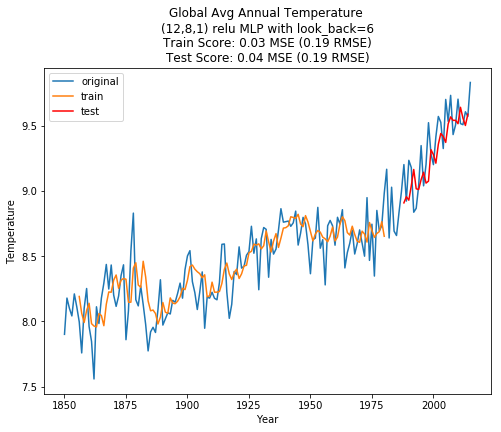

In [241]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Create datasets for plotting
data=df0Annual[['at']]
trainDf = pd.DataFrame(np.nan, index=data.index, columns=data.columns)
trainDf.iloc[look_back:len(trainPredict)+look_back] = trainPredict

testDf = pd.DataFrame(np.nan, index=dataset.index, columns=dataset.columns)
testDf.iloc[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict  

# trainDf.head(7)
# testDf.tail(7)

trainPredictPlot = trainDf
testPredictPlot  = testDf

# plot baseline and predictions
plt.figure(figsize=(8,6))
plt.plot(data,label='original')
plt.plot(trainPredictPlot,label='train')
plt.plot(testPredictPlot,color='red',label='test')
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Global Avg Annual Temperature \n' + \
          '(12,8,1) relu MLP with look_back='+ str(look_back) + '\n' + \
'Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)) + '\n' + \
'Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore))  )
plt.savefig('GlobalTemperatureMLP.png')

# Repeat for different look_back

## Setup input data for autoregression for chosen look_back

In [243]:
# re-shape dataset for autoregression 
nvars=2
look_back=12
trainX = np.zeros((len(train)-look_back-1,  2*look_back)) 
trainY = np.zeros((len(train)-look_back-1,  nvars))
testX  = np.zeros((len(test) -look_back-1,  2*look_back)) 
testY  = np.zeros((len(test) -look_back-1,  nvars))

for col in train.columns: #iterating over input variables at, atu
    ii=train.columns.get_loc(col) #index of column (at, atu)
    jj=ii*look_back # index for nvars*look_back columns
    #print(ii,'jj=',jj, col)
    # input to create_dataset should be a series of single numbers
    trainX[:,jj:jj+look_back] , trainY[:,ii] = create_dataset(train.values[:,[ii]], look_back)
    testX [:,jj:jj+look_back] , testY [:,ii] = create_dataset( test.values[:,[ii]], look_back)
trainY = trainY[:,0]  #model ouputs just 'at'
testY = testY[:,0]

## Train the model

In [244]:
# create and fit Multilayer Perceptron model
# inputs are at and atu for prior times (t0-1, t0-2,...)
# output is 'at' at the to

startTimer = ti.default_timer()
model = Sequential()
model.add(Dense(12, input_dim=2*look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)
stopTimer = ti.default_timer()
beep(3);

Epoch 1/400
0s - loss: 15.2043
Epoch 2/400
0s - loss: 0.0789
Epoch 3/400
0s - loss: 0.0494
Epoch 4/400
0s - loss: 0.0491
Epoch 5/400
0s - loss: 0.0461
Epoch 6/400
0s - loss: 0.0477
Epoch 7/400
0s - loss: 0.0485
Epoch 8/400
0s - loss: 0.0429
Epoch 9/400
0s - loss: 0.0456
Epoch 10/400
0s - loss: 0.0470
Epoch 11/400
0s - loss: 0.0430
Epoch 12/400
0s - loss: 0.0480
Epoch 13/400
0s - loss: 0.0414
Epoch 14/400
0s - loss: 0.0464
Epoch 15/400
0s - loss: 0.0388
Epoch 16/400
0s - loss: 0.0498
Epoch 17/400
0s - loss: 0.0558
Epoch 18/400
0s - loss: 0.0432
Epoch 19/400
0s - loss: 0.0487
Epoch 20/400
0s - loss: 0.0425
Epoch 21/400
0s - loss: 0.0402
Epoch 22/400
0s - loss: 0.0435
Epoch 23/400
0s - loss: 0.0415
Epoch 24/400
0s - loss: 0.0395
Epoch 25/400
0s - loss: 0.0413
Epoch 26/400
0s - loss: 0.0497
Epoch 27/400
0s - loss: 0.0416
Epoch 28/400
0s - loss: 0.0399
Epoch 29/400
0s - loss: 0.0417
Epoch 30/400
0s - loss: 0.0402
Epoch 31/400
0s - loss: 0.0393
Epoch 32/400
0s - loss: 0.0519
Epoch 33/400
0s 

In [245]:
# Estimate model performance
print('(12,8,1) relu MLP with look_back=',look_back)
# Time to train
Time2train = round(stopTimer - startTimer,3)
print('Time2train = ',Time2train)
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

(12,8,1) relu MLP with look_back= 12
Time2train =  79.854
Train Score: 0.06 MSE (0.24 RMSE)
Test Score: 0.02 MSE (0.14 RMSE)


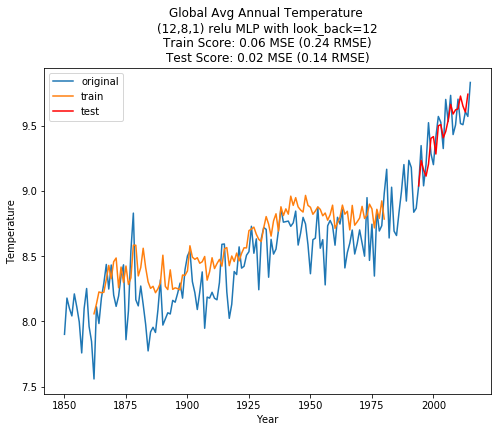

In [246]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Create datasets for plotting
data=df0Annual[['at']]
trainDf = pd.DataFrame(np.nan, index=data.index, columns=data.columns)
trainDf.iloc[look_back:len(trainPredict)+look_back] = trainPredict

testDf = pd.DataFrame(np.nan, index=dataset.index, columns=dataset.columns)
testDf.iloc[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict  

# trainDf.head(7)
# testDf.tail(7)

trainPredictPlot = trainDf
testPredictPlot  = testDf

# plot baseline and predictions
plt.figure(figsize=(8,6))
plt.plot(data,label='original')
plt.plot(trainPredictPlot,label='train')
plt.plot(testPredictPlot,color='red',label='test')
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Global Avg Annual Temperature \n' + \
          '(12,8,1) relu MLP with look_back='+ str(look_back) + '\n' + \
'Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)) + '\n' + \
'Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore))  )
plt.savefig('GlobalTemperatureMLP.png')

In [247]:
predictDf = testPredictPlot[['at']]  #later, merge trainPredictPlot
atuVal=df0Annual.loc[2000:2010,'atu'].mean()*2

# Make predictions out 40 years
for year in range(2013,2040):
    inputL=[]
    inputL[0:look_back]=predictDf.ix[year-look_back:year-1,0].values
    inputL[look_back:2*look_back]=[atuVal]*look_back
    inputL=np.array(inputL, dtype=float).reshape((-1, 2*look_back))
    outVal=model.predict(inputL)[0][0]
    predictDf.ix[year,0]=outVal
predictDf = predictDf.loc[2013:]

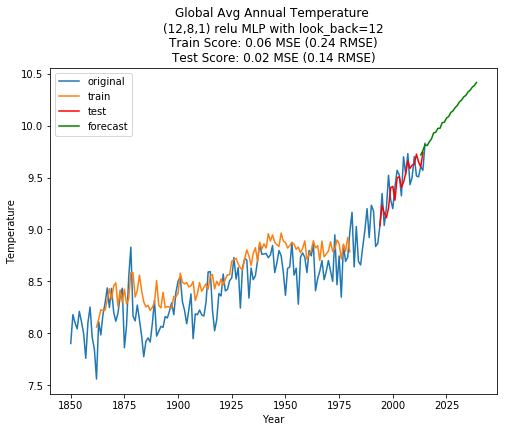

In [248]:
# append output to predictDf
# predictDf.loc[2013:,:]


# plot baseline and predictions
plt.figure(figsize=(8,6))
plt.plot(data,label='original')
plt.plot(trainPredictPlot,label='train')
plt.plot(testPredictPlot,color='red',label='test')
plt.plot(predictDf,color='green',label='forecast')
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Global Avg Annual Temperature \n' + \
          '(12,8,1) relu MLP with look_back='+ str(look_back) + '\n' + \
'Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)) + '\n' + \
'Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore))  )
plt.savefig('GlobalTemperatureMLP.png')

In [252]:
# Output the data
globalTemps=pd.DataFrame(index=range(1850,2040))
globalTemps['at-historical']=df0Annual.loc[:,'at']
globalTemps['at-forecasted']=predictDf.loc[:,'at']
globalTemps.head(3)
globalTemps.tail(3)
globalTemps.to_csv('../Output/US_GlobalTemps.csv')

In [ ]:
# Read off years of .5C increase

In [ ]:
# Read off number of very hot days

# Compare to C02 levels

In [319]:
co2=pd.read_csv("../Input/CO2/archive.csv") #units?
co2.head(5)
#set(co2['Year']) #1958 - 2017
co2=co2.loc[co2['Year'].isin(range(1959,2013))]
co2['Year']=co2['Year'].astype(str)
co2['Month']=co2['Month'].astype(str)

co2['dt'] = co2[['Year', 'Month']].apply(lambda x: '-'.join(x), axis=1)
co2 = co2.rename(columns={'Seasonally Adjusted CO2 Fit (ppm)':'CO2'})
co2 = co2[['dt','CO2','Year']]
#co2['dt']=co2['dt'].astype(float)
co2.head(3)

,dt,CO2,Year
12,1959-1,315.57,1959
13,1959-2,315.63,1959
14,1959-3,315.69,1959


In [320]:
graph = co2.reset_index()
graph = graph.set_index('dt')
graph = graph.fillna(0)
graph.head(3)

,index,CO2,Year
dt,,,
1959-1,12,315.57,1959
1959-2,13,315.63,1959
1959-3,14,315.69,1959


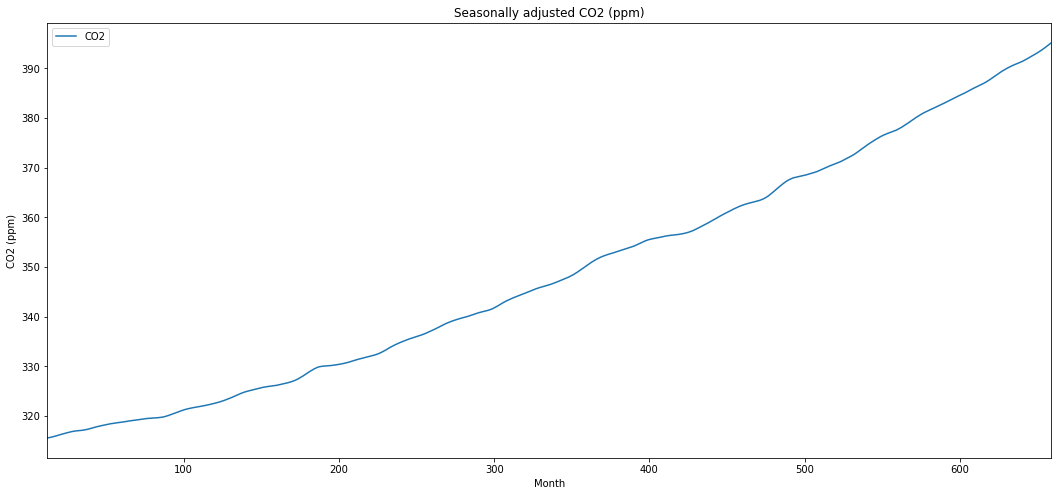

In [321]:
graph = co2['CO2']
plt.figure(figsize=(8,6))
graph.plot()
#plt.plot(co2,color='red',label='test')
plt.legend(loc='upper left')
plt.xlabel('Month')
plt.ylabel('CO2 (ppm)')
plt.title('Seasonally adjusted CO2 (ppm)')
fig=plt.gcf()
fig.set_size_inches(18,8)

In [322]:
globalMonthly=df0.loc[df0['year'].isin(range(1959,2013))]
globalMonthly.head(3)

,dt,at,atu,year,month
2508,1959-01,2.959,0.077,1959,1
2509,1959-02,3.330,0.126,1959,2
2510,1959-03,5.854,0.199,1959,3


# Plot Temp as a function of CO2 to view correlation.

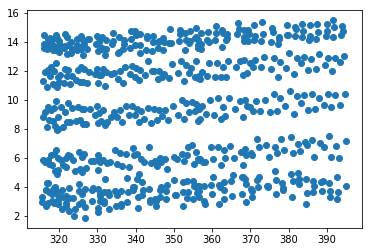

In [324]:
yL=globalMonthly['at']
xL=co2['CO2']
pairsL=list(zip(xL,yL))
pairsL[0:5]

# plt.scatter(xL,yL,color='red',label='test')
plt.scatter(xL,yL)
plt.show()

In [325]:
co2Annual=co2.groupby('Year').mean()
globalAnnual=globalMonthly.groupby('year').mean()

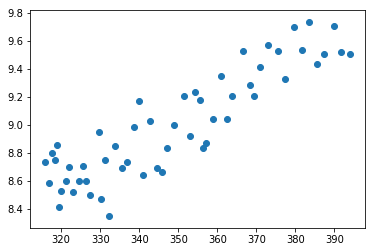

In [326]:
yL=globalAnnual['at']
xL=co2Annual['CO2']

# plt.scatter(xL,yL,color='red',label='test')
plt.scatter(xL,yL)
plt.show()

In [ ]:
# in progress

In [ ]:
# # convert an array of values into a datasets of the same length
# def create_plotdata(dataset, trainPredict, testPredict, look_back=1):
#     trainPredictPlot = np.empty_like(dataset)
#     trainPredictPlot[:, :] = np.nan
#     trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

#     testPredictPlot = np.empty_like(dataset)
#     testPredictPlot[:, :] = np.nan
#     testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict  
#     return np.array(trainPredictPlot), np.array(testPredictPlot)
#trainPredictPlot, testPredictPlot = create_plotdata(data, trainPredict, testPredict, look_back)


In [ ]:
# fix 
# import numpy as np

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

# # This does work by using only one sample:
# data = [[0,0,0,0,0,0,0,0,0,2,1]]
# data = np.array(data, dtype=float)
# target = [0,0,0,0,0,0,0,0,2,1,0]
# target = np.array(target, dtype=float)

# data = data.reshape((1, 1, 11)) # Single batch, 1 time steps, 11 dimentions
# target = target.reshape((-1, 11)) # Corresponds to shape (None, 11)


# # Build Model
# model = Sequential()  
# model.add(LSTM(11, input_shape=(1, 11), unroll=True))
# model.add(Dense(11))
# model.compile(loss='mean_absolute_error', optimizer='adam')
# model.fit(data, target, nb_epoch=1000, batch_size=1, verbose=2)

# # Do the output values match the target values?
# predict = model.predict(data)
# print repr(data)
# print repr(predict)